In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from pynwb import NWBFile, TimeSeries, NWBHDF5IO
import xarray as xr
import zarr

nwb_folder = '/root/capsule/data/s3/export/nwb/'
zarr_folder = '/root/capsule/data/s3/export/psth/'

Load xarray dataset from zarr

In [14]:
fname = '482353_36_psth.zarr'
ds_out = xr.open_zarr(f'{zarr_folder}/{fname}', consolidated=True)
ds_out

<xarray.Dataset>
Dimensions:                           (trial: 471, finished_trial: 450,
                                       period: 7, unit: 578, t_to_choice: 699,
                                       t_to_go_cue: 699, t_to_iti_start: 1299)
Coordinates:
  * finished_trial                    (finished_trial) int64 1 2 3 ... 469 470
  * period                            (period) object 'before_2' ... 'iti_las...
  * t_to_choice                       (t_to_choice) float64 -1.995 ... 4.985
  * t_to_go_cue                       (t_to_go_cue) float64 -1.995 ... 4.985
  * t_to_iti_start                    (t_to_iti_start) float64 -2.995 ... 9.985
  * trial                             (trial) int64 1 2 3 4 ... 468 469 470 471
  * unit                              (unit) int32 0 1 2 3 4 ... 574 575 576 577
Data variables: (12/27)
    choice_lr                         (trial) float64 ...
    choice_x                          (trial) object ...
    choice_y                          (trial) object ...
    early_lick                        (trial) object ...
    left_                             (trial) object ...
    left_action_value                 (trial) float64 ...
    ...                                ...
    spike_count_aligned_to_go_cue     (unit, trial, t_to_go_cue) int8 ...
    spike_count_aligned_to_iti_start  (unit, trial, t_to_iti_start) int8 ...
    subject_id                        (trial) int64 ...
    total_action_value                (trial) float64 ...
    unit_period_firing_rate           (unit, period, trial) float64 ...
    unit_period_spike_counts          (unit, period, trial) float64 ...
Attributes:
    align_tos:  ['go_cue', 'choice', 'iti_start']
    bin_size:   0.01
    model_id:   20
    unit_keys:  [{'clustering_method': 'kilosort2', 'insertion_number': 1, 's...

Spike count aligned to `go cue`, `choice`, and `iti start`

In [15]:
ds_out.spike_count_aligned_to_go_cue

<xarray.DataArray 'spike_count_aligned_to_go_cue' (unit: 578, trial: 471,
                                                   t_to_go_cue: 699)>
[190294362 values with dtype=int8]
Coordinates:
  * t_to_go_cue  (t_to_go_cue) float64 -1.995 -1.985 -1.975 ... 4.975 4.985
  * trial        (trial) int64 1 2 3 4 5 6 7 8 ... 465 466 467 468 469 470 471
  * unit         (unit) int32 0 1 2 3 4 5 6 7 ... 571 572 573 574 575 576 577

Get unit keys from `dataset.attrs`

In [19]:
df_unit_key = pd.DataFrame.from_dict(ds_out.attrs['unit_keys'])
df_unit_key

,clustering_method,insertion_number,session,subject_id,unit
0,kilosort2,1,36,482353,2
1,kilosort2,1,36,482353,15
2,kilosort2,1,36,482353,16
3,kilosort2,1,36,482353,19
4,kilosort2,1,36,482353,23
...,...,...,...,...,...
573,kilosort2,3,36,482353,219
574,kilosort2,3,36,482353,222
575,kilosort2,3,36,482353,223
576,kilosort2,3,36,482353,226


Get aligned binned spikes from selected unit

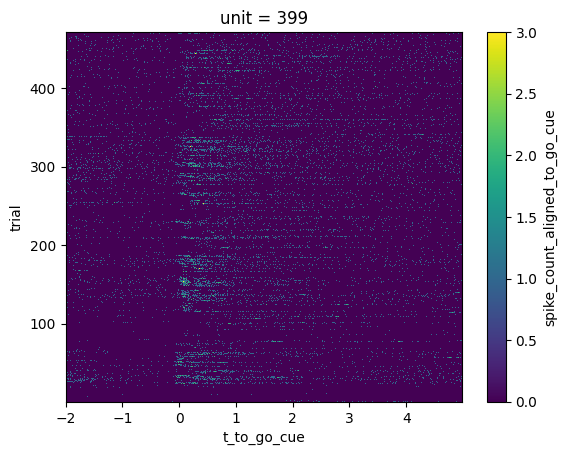

In [25]:
unit_ind = df_unit_key.query('insertion_number == 2 & unit == 362').index
ds_out.spike_count_aligned_to_go_cue[unit_ind, :, :].plot()

Get mean firing in different periods

In [34]:
ds_out.unit_period_firing_rate

<xarray.DataArray 'unit_period_firing_rate' (unit: 578, period: 7, trial: 471)>
[1905666 values with dtype=float64]
Coordinates:
  * period   (period) object 'before_2' 'delay' ... 'iti_first_2' 'iti_last_2'
  * trial    (trial) int64 1 2 3 4 5 6 7 8 9 ... 464 465 466 467 468 469 470 471
  * unit     (unit) int32 0 1 2 3 4 5 6 7 8 ... 570 571 572 573 574 575 576 577

In [60]:
period_firing_this = ds_out.unit_period_firing_rate.sel(period='go_to_end', unit=unit_ind)
period_firing_this[0, :]

<xarray.DataArray 'unit_period_firing_rate' (trial: 471)>
[471 values with dtype=float64]
Coordinates:
    period   <U9 'go_to_end'
  * trial    (trial) int64 1 2 3 4 5 6 7 8 9 ... 464 465 466 467 468 469 470 471
    unit     int32 399

Get behavioral variables

In [41]:
dQ = ds_out.relative_action_value_lr
dQ

<xarray.DataArray 'relative_action_value_lr' (trial: 471)>
[471 values with dtype=float64]
Coordinates:
  * trial    (trial) int64 1 2 3 4 5 6 7 8 9 ... 464 465 466 467 468 469 470 471

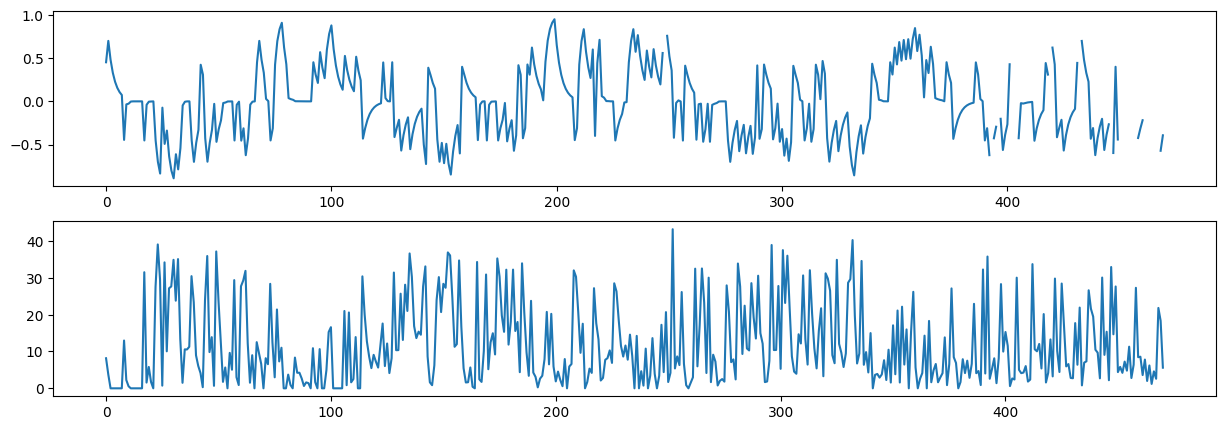

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(15, 5))
axs[0].plot(dQ)
axs[1].plot(period_firing_this[0, :])

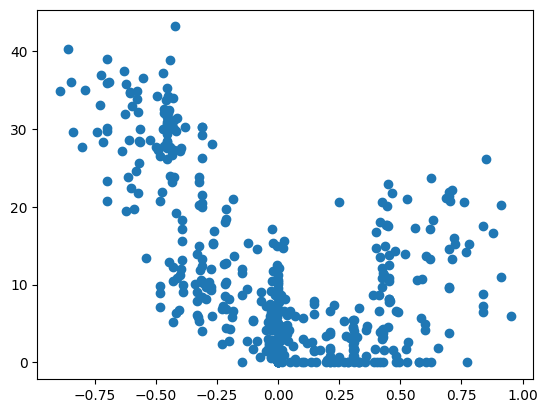

In [62]:
plt.plot(dQ, period_firing_this[0, :], 'o')